## Project: Dog Breed Classifier

In this project I build two models based on the pre-trained architectures based on the VGG16 and ResNet models.

Used Dataset from: http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
# !pip install tensorflow==2.15.0

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# ! cp /content/drive/MyDrive/Dog_Breed_Dataset.zip .

In [5]:
# ! unzip Dog_Breed_Dataset.zip

In [2]:
!python3 --version

Python 3.11.9


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from datetime import datetime
from PIL import Image

In [4]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)

In [8]:
# set the path for the data base containing the images
file_path = "/content/Dog_Breed_Dataset"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [5]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16, ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Shuffle images from directory into train, valid, and test sets

In [ ]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [11]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True,
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)),
                                               shuffle=True,random_state=rs)

                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [12]:
# Print the count of items from each class

count = 0
for folder in os.listdir(train_dir):
    folder_pics = len(os.listdir(os.path.join(train_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The schipperke class has 107 pictures.
The komondor class has 107 pictures.
The keeshond class has 110 pictures.
The Irish_wolfhound class has 152 pictures.
The Irish_setter class has 108 pictures.
The clumber class has 104 pictures.
The Great_Dane class has 109 pictures.
The Samoyed class has 152 pictures.
The Walker_hound class has 107 pictures.
The toy_poodle class has 105 pictures.
The Airedale class has 141 pictures.
The Labrador_retriever class has 119 pictures.
The Cardigan class has 108 pictures.
The collie class has 107 pictures.
The wire-haired_fox_terrier class has 109 pictures.
The whippet class has 130 pictures.
The Scottish_deerhound class has 162 pictures.
The Italian_greyhound class has 127 pictures.
The black-and-tan_coonhound class has 111 pictures.
The boxer class has 105 pictures.
The briard class has 106 pictures.
The Leonberg class has 146 pictures.
The pug class has 139 pictures.
The basset class has 122 pictures.
The papillon class has 137 pictures.
The Pembroke

## Let us have a look at the classes we are going to classify

In [13]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(train_dir):
    pics = random.choice(os.listdir(os.path.join(train_dir, folder)))
    path_pic = os.path.join(train_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

#print(image_examples_dict)

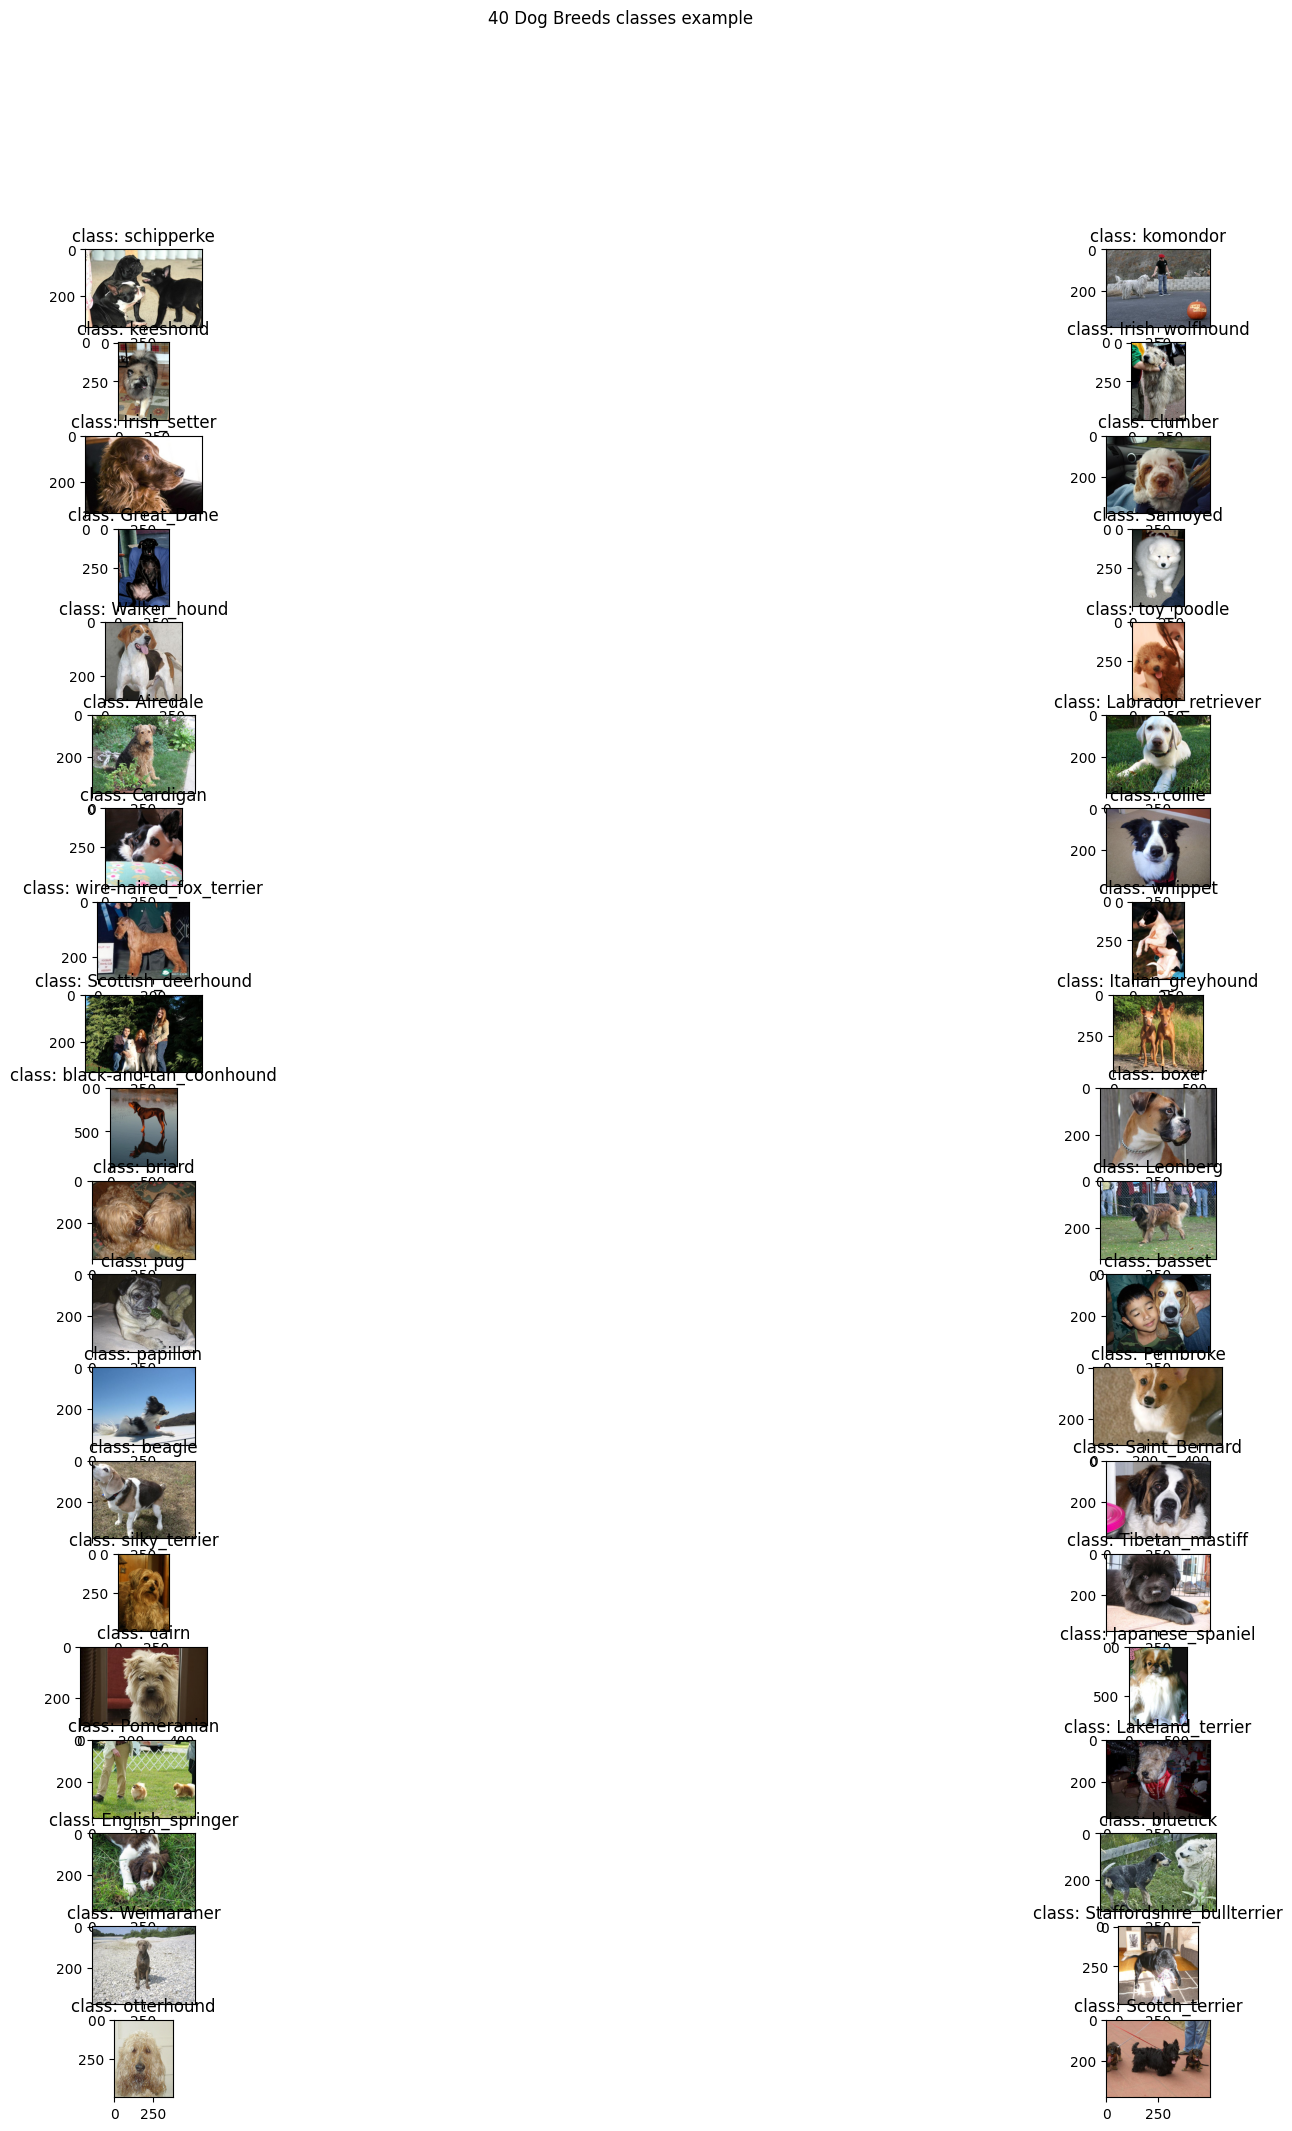

In [14]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(24, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('40 Dog Breeds classes example')
plt.show()

## Model definition


In [7]:
# here I define some important parameter that are going to be used in both models

image_resize = 224

batch_size_training = 56
batch_size_validation = 56

num_epochs = 8

Now we can generate train and validation set with ImageDataGenerator

In [8]:
def get_data_generator(preprocessinput):
  # instantiate the image data generator
  data_generator = ImageDataGenerator(preprocessing_function=preprocessinput)

  train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

  validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
    )

  test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
  )
  return train_generator, validation_generator, test_generator

# Build the models

We first define a helper function to save the trained models as h5

In [9]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "."
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")


---

## ResNet50

### Instantiate the generator for resnet50

In [18]:
train_generator_r, validation_generator_r, test_generator_r = get_data_generator(preprocess_input_resnet)

num_classes = train_generator_r.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_r)
steps_per_epoch_validation = len(validation_generator_r)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [19]:
def get_model_resnet():

  base_model = ResNet50(input_shape=(image_resize, image_resize, 3),
                          weights='imagenet', include_top=True)

  #Freeze layers from ResNet backbone (not to be trained)
  for layer in base_model.layers:
      layer.trainable=False

  x = base_model.get_layer('conv5_block3_out').output
  x = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)
  x = Dropout(0.3, name="Dopout")(x)
  preds = Dense(num_classes, activation='softmax', name='predictions')(x)


  model = Model(inputs=base_model.input, outputs=preds)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Make the last convolutional layer trainable for fine tuning
  model.get_layer('conv5_block3_3_conv').trainable = True
  model.get_layer('conv5_block3_3_bn').trainable = True

  return model

In [20]:
model_resnet = get_model_resnet()

model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [21]:
%%time

start_datetime = datetime.now()

fit_resnet = model_resnet.fit(
    train_generator_r,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_r,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
257/257 [==============================] - 74s 253ms/step - loss: 1.9568 - accuracy: 0.5100 - val_loss: 0.9854 - val_accuracy: 0.7078
Epoch 2/8
257/257 [==============================] - 62s 239ms/step - loss: 0.7725 - accuracy: 0.7681 - val_loss: 0.8743 - val_accuracy: 0.7362
Epoch 3/8
257/257 [==============================] - 62s 239ms/step - loss: 0.5534 - accuracy: 0.8268 - val_loss: 0.8676 - val_accuracy: 0.7391
Epoch 4/8
257/257 [==============================] - 62s 240ms/step - loss: 0.4295 - accuracy: 0.8639 - val_loss: 0.8630 - val_accuracy: 0.7498
Epoch 5/8
257/257 [==============================] - 63s 243ms/step - loss: 0.3527 - accuracy: 0.8870 - val_loss: 0.8514 - val_accuracy: 0.7546
Epoch 6/8
257/257 [==============================] - 62s 239ms/step - loss: 0.2921 - accuracy: 0.9065 - val_loss: 0.8479 - val_accuracy: 0.7578
Epoch 7/8
257/257 [==============================] - 61s 237ms/step - loss: 0.2427 - accuracy: 0.9243 - val_loss: 0.8592 - val_accuracy:

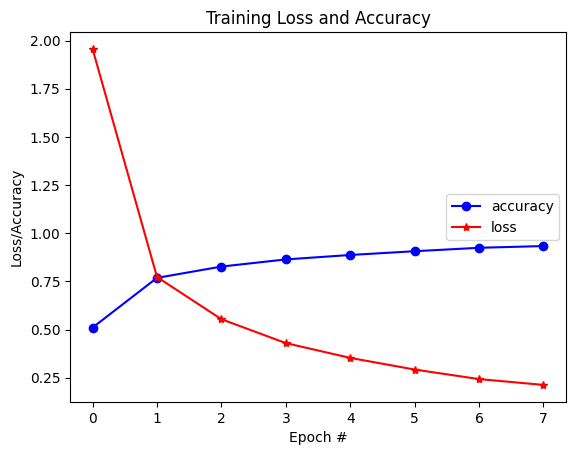

In [22]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_resnet.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_resnet.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [23]:
eval_resnet = model_resnet.evaluate(test_generator_r)
print('ResNet Test loss: ', eval_resnet[0])
print('ResNet Test Accuracy: ', eval_resnet[1])

3145/3145 [==============================] - 39s 12ms/step - loss: 0.8363 - accuracy: 0.7657
ResNet Test loss:  0.8362960815429688
ResNet Test Accuracy:  0.765659749507904


In [24]:
# Save the model to a file
save_model(model_resnet, "classifier_resnet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model created


---

# VGG16

### Instantiate the generator for VGG

In [25]:
train_generator_vgg, validation_generator_vgg, test_generator_vgg = get_data_generator(preprocess_input_vgg)

num_classes = train_generator_vgg.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_vgg)
steps_per_epoch_validation = len(validation_generator_vgg)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [26]:
def get_model_vgg():

    base_model = VGG16(input_shape=(image_resize, image_resize, 3),
                       weights='imagenet', include_top=True)

    #Freeze layers from ResNet backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    x = base_model.get_layer('block5_conv3').output

    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.3)(x)

    preds = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=preds)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [27]:
model_vgg = get_model_vgg()

model_vgg.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [28]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator_vgg,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_vgg,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
257/257 [==============================] - 94s 323ms/step - loss: 6.5743 - accuracy: 0.1666 - val_loss: 2.2163 - val_accuracy: 0.4737
Epoch 2/8
257/257 [==============================] - 77s 298ms/step - loss: 2.7251 - accuracy: 0.4323 - val_loss: 1.6798 - val_accuracy: 0.5861
Epoch 3/8
257/257 [==============================] - 76s 297ms/step - loss: 1.9160 - accuracy: 0.5513 - val_loss: 1.4916 - val_accuracy: 0.6216
Epoch 4/8
257/257 [==============================] - 77s 298ms/step - loss: 1.5445 - accuracy: 0.6156 - val_loss: 1.3554 - val_accuracy: 0.6468
Epoch 5/8
257/257 [==============================] - 77s 299ms/step - loss: 1.3056 - accuracy: 0.6524 - val_loss: 1.3368 - val_accuracy: 0.6564
Epoch 6/8
257/257 [==============================] - 77s 299ms/step - loss: 1.1915 - accuracy: 0.6822 - val_loss: 1.3385 - val_accuracy: 0.6519
Epoch 7/8
257/257 [==============================] - 76s 297ms/step - loss: 1.0586 - accuracy: 0.7054 - val_loss: 1.3324 - val_accuracy:

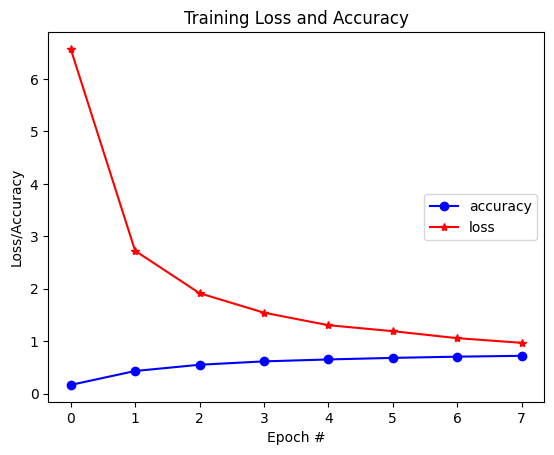

In [29]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [30]:
eval_vgg = model_vgg.evaluate(test_generator_vgg)
print('VGG16 Test loss: ', eval_vgg[0])
print('VGG16 Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 32s 10ms/step - loss: 1.3075 - accuracy: 0.6684
VGG16 Test loss:  1.3075487613677979
VGG16 Test Accuracy:  0.6683624982833862


In [31]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg_model.h5")

model created


#  Persist the models and evaluate on the test set

In [6]:
# load the models

model_resnet = load_model('classifier_resnet_model.h5')

#model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

To summarize, the accuracy metric on the test set was


  ResNet: 0.7663

  VGG16: 0.6668
  

---

# Class Activation Maps

  - CAM highlights the regions in an image that a CNN considers important for making a specific classification decision.

  - It uses the output of the last convolutional layer and the corresponding weights for a particular class.

  - The result is a heatmap that can be visualized on the input image to understand the model's focus areas for that prediction.

  CAM is particularly useful for interpretability, helping users to understand and trust the model's decisions

In [73]:
def activation_map(model0, img_path, preprocess_input):
    """ This function takes a model, an image path and a preprocess_input function
    and returns the class activation map for the image"""

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

    # Create a new model that will output the activations of the desired intermediate layers
    layer_names = ['conv5_block3_3_conv', 'predictions']
    outputs_dict = dict([(name, model0.get_layer(name).output) for name in layer_names])
    model = Model(inputs=model0.input, outputs=outputs_dict)

    # Get the prediction layer weights
    W = model.get_layer('predictions').get_weights()[0] # (2048, num_classes)

    # Preprocess the image
    x = preprocess_input(np.expand_dims(img, axis=0))

    # features is a dictionary to capture the activations of the intermediate layers
    features = model.predict(x)

    fmaps = features["conv5_block3_3_conv"][0] # (7, 7, 2048)

    # Get the predicted class activation map
    probs = features["predictions"]
    pred = np.argmax(probs)

    weights = W[:, pred] # (2048,)

    cam = np.dot(fmaps, weights) # (7, 7)

    # Resize the CAM to the size of the input image
    # (32, 32) x (7, 7) = (224, 224)
    am = sp.ndimage.zoom(cam, (32, 32), order=1)

    # Plot the original image and the CAM
    fig = plt.figure(figsize=(4, 4))
    
    plt.imshow(img, alpha=0.8)  # Base image
    plt.imshow(am, cmap='jet', alpha=0.4)  # CAM overlay
    plt.axis('off')
    #plt.title('Class Activation Map')

    # Convert the figure to a canvas and then to a numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the rendered figure to a NumPy array
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Optionally, close the plot if you don't want it displayed
    plt.close(fig)

    return img_array

1/1 [==============================] - 0s 428ms/step
(400, 400, 3)


/var/folders/61/66jts0q11blds6prm54dvd1m0000gp/T/ipykernel_46120/4208820733.py:48: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


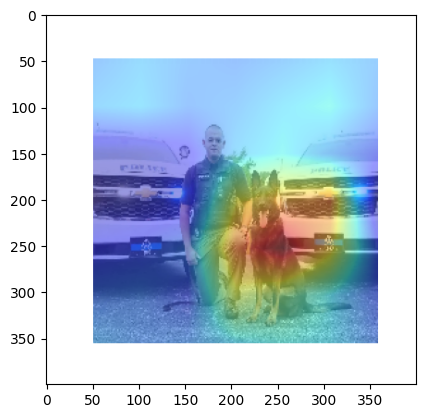

In [74]:
am = activation_map(model_resnet, "officer-with-german-shepherd.jpg", preprocess_input_resnet)
print(am.shape)
plt.imshow(am)